In [1]:
import sys

sys.path.append("../berries")


In [3]:
from my_datasets import Supervised, load_supervised

#n_samples, d_x, d_y, X, y, X_test, y_test = load_supervised("fashion_mnist")
n_samples, d_x, d_y, X, y, X_test, y_test = load_supervised("mnist")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [4]:
X = X / 255.0
X_test = X_test / 255.0

In [101]:
d_h_layer = 256
d_h = 256
n_layers = 1
d_in = d_x
# d_out = d_y
d_out = d_x
d_vae_h = 128
beta = 0.9

In [102]:

import nn
import importlib
importlib.reload(nn)
from nn import mglu_net_config, mglu_net, rmglu_net
from pf import F, _

from jax.numpy import mean, exp


def vae_config(d_in, d_h_layer, d_vae_h, d_h, n_layers, init):
    return {
        "encoder":mglu_net_config(d_in, d_h_layer, 2 * d_vae_h, d_h, n_layers, init),
        "decoder": mglu_net_config(d_vae_h, d_h_layer, d_in, d_h, n_layers, init)}

def vae(W, x, noise):
    h = mglu_net(x, W["encoder"])
    mu, log_sigma = h[:d_vae_h], h[d_vae_h:]
    z = mu + noise * log_sigma
    xp = mglu_net(z, W["decoder"])
    return xp, mu, log_sigma



def vae_loss(W, x, noise):
    xp, mu, log_sigma = vae(W, x, noise)
    return ((xp - x) ** 2).mean() - 0.5 * beta * (1 + log_sigma - mu ** 2 - exp(log_sigma)).mean()


loss_b = F(vae_loss).vmap((None, 0, 0), 0)
loss_bm = loss_b >> mean

def vae_test_loss(W, x):
    xp, _, _ = vae(W, x, 0)
    return ((xp - x) ** 2).mean()

test_loss_b = F(vae_test_loss).vmap((None, 0), 0)
test_loss_bm = test_loss_b >> mean

vae_b = F(vae).vmap((None, 0, 0), 0)


In [103]:
import optax
from jax import grad, jit
from jax.tree_util import tree_map
import random_utils
import init_utils
from nn import init_weights, fmt_weights

seed = 0
key_gen = random_utils.infinite_safe_keys(seed)



lr = 0.001
mask_fn = lambda p: tree_map(lambda x: not isinstance(x, int), p)
# opt = optax.multi_transform({"sgd": optax.rmsprop(lr), "zero": optax.set_to_zero()}, mask_fn)
opt = optax.masked(optax.rmsprop(lr), mask_fn)

def get_noise(size, key):
    return init_utils.normal_init(key, sd=0.1, shape=[size, d_x])

method = {"type": "zer0", "std": 0.001}
# method = {"type": "normal", "std": 0.01}
# W = init_weights(next(key_gen), mglu_net_config(d_in, d_h_layer, d_out, d_h, n_layers, method))
W = init_weights(next(key_gen), vae_config(d_in, d_h_layer, d_vae_h, d_h, n_layers, method))
loss0 = test_loss_bm(W, X_test)
print(loss0)
print(fmt_weights(W)[0])
state = opt.init(W)

@jit
def update(W, x, noise, opt_state):
    grads = grad(loss_bm)(W, x, noise)
    updates, opt_state = opt.update(grads, opt_state)
    new_W = optax.apply_updates(W, updates)
    return new_W, opt_state

0.29340643
encoder:
    mglu:
        tuple:
            sglu:
                wv:
                    array shape: (784, 256)
                wu:
                    array shape: (784, 256)
                wo:
                    array shape: (256, 256)
                total params: 466944
            rmsn:
                d:
                    256.0
                total params: 1
            total params: 466945
        tuple:
            sglu:
                wv:
                    array shape: (256, 256)
                wu:
                    array shape: (256, 256)
                wo:
                    array shape: (256, 256)
                total params: 196608
            rmsn:
                d:
                    256.0
                total params: 1
            total params: 196609
        total params: 663554
    sglu:
        wv:
            array shape: (256, 256)
        wu:
            array shape: (256, 256)
        wo:
            array shape: (256, 256)
       

396.65436 0.107498385


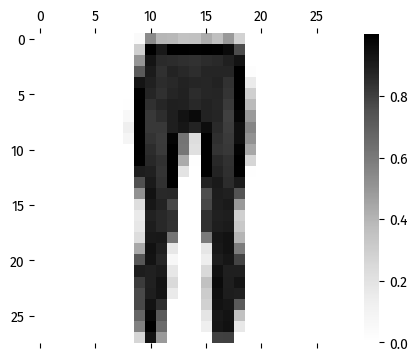

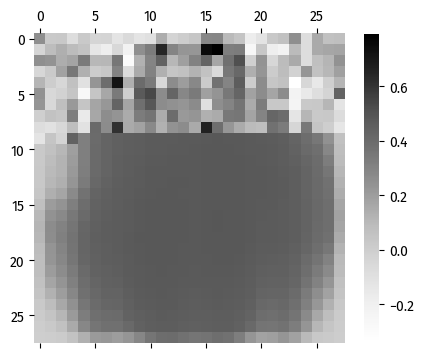

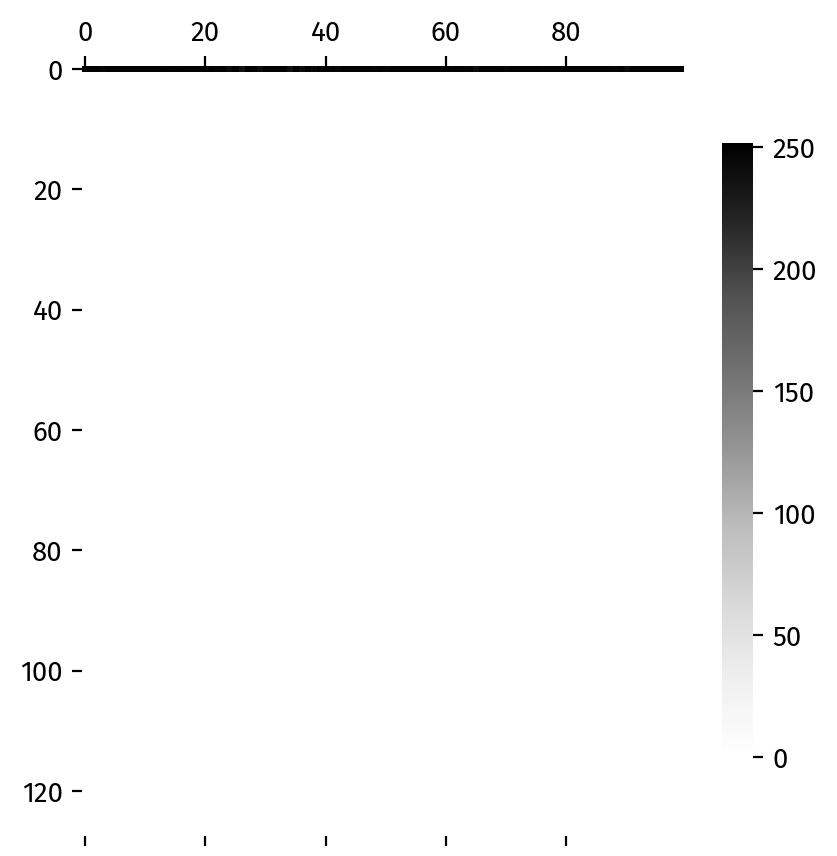

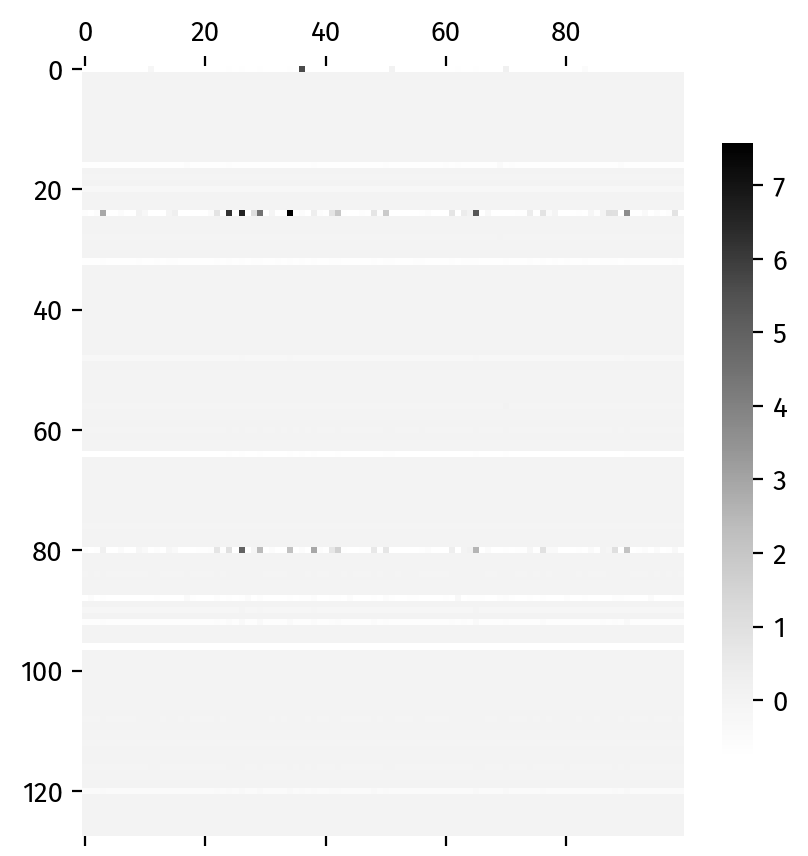

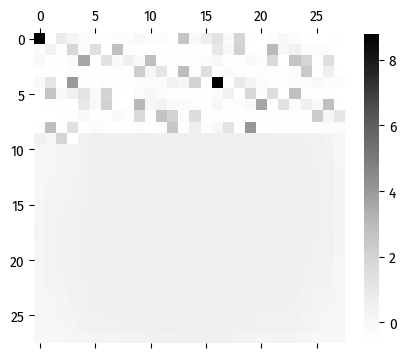

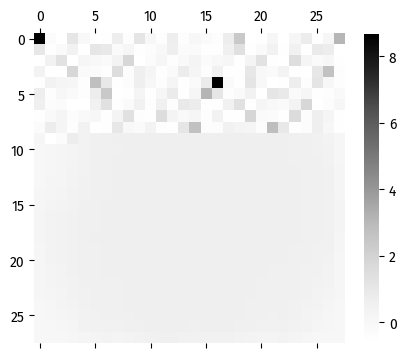

0.22634028 0.0948536
0.09023757 0.0872453
0.07835792 0.07545873
0.06112904 0.059899975
0.06241259 0.06255964


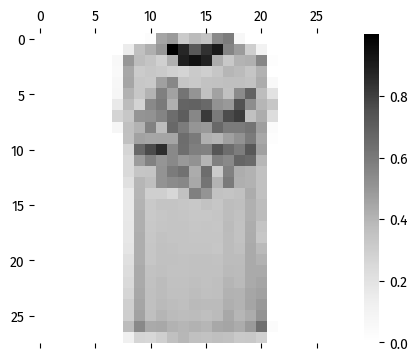

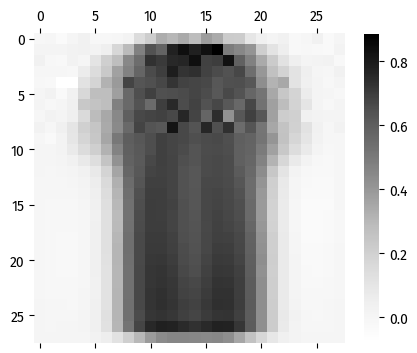

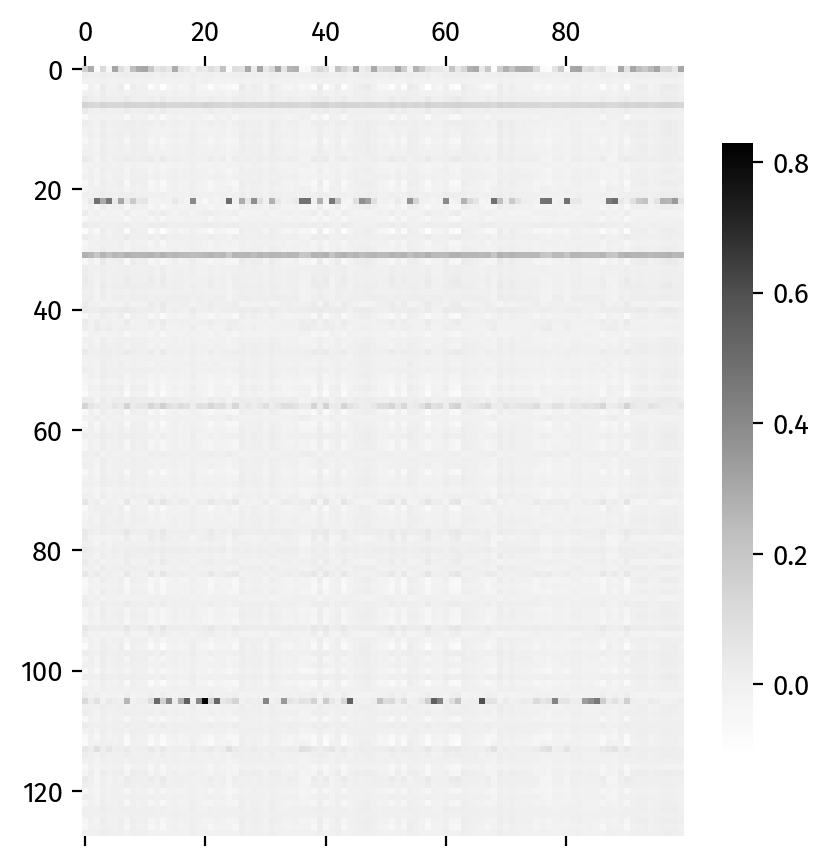

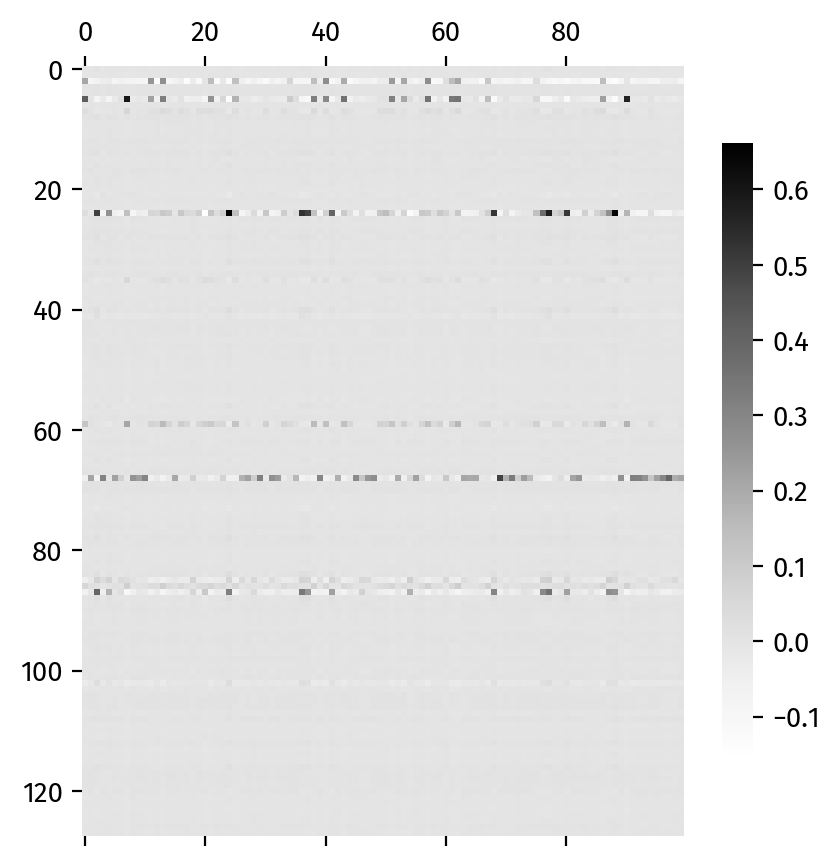

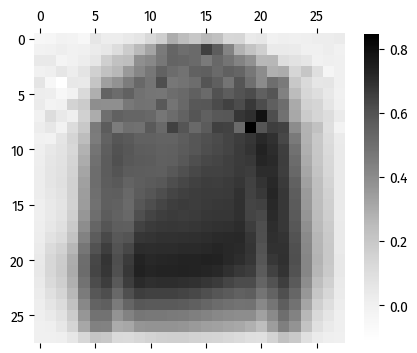

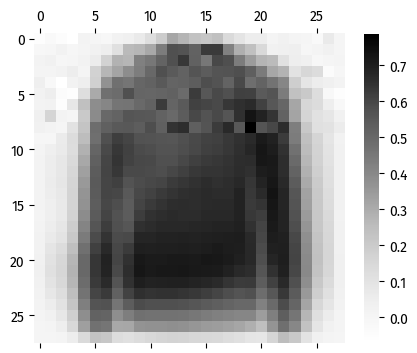

0.054263905 0.054128412
0.05728863 0.055103734
0.047233354 0.046598412
0.044378478 0.043141667
0.04742001 0.046357937


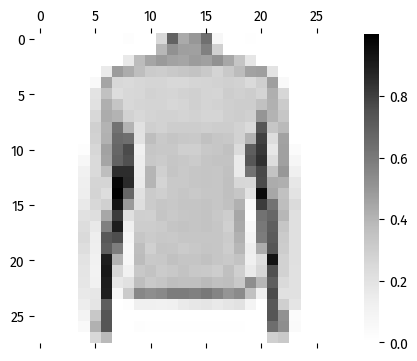

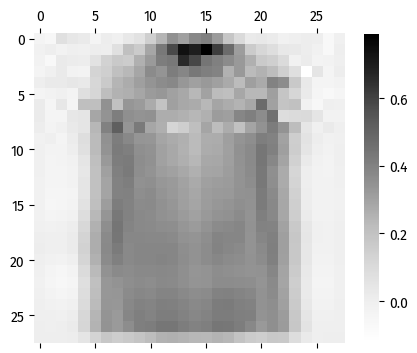

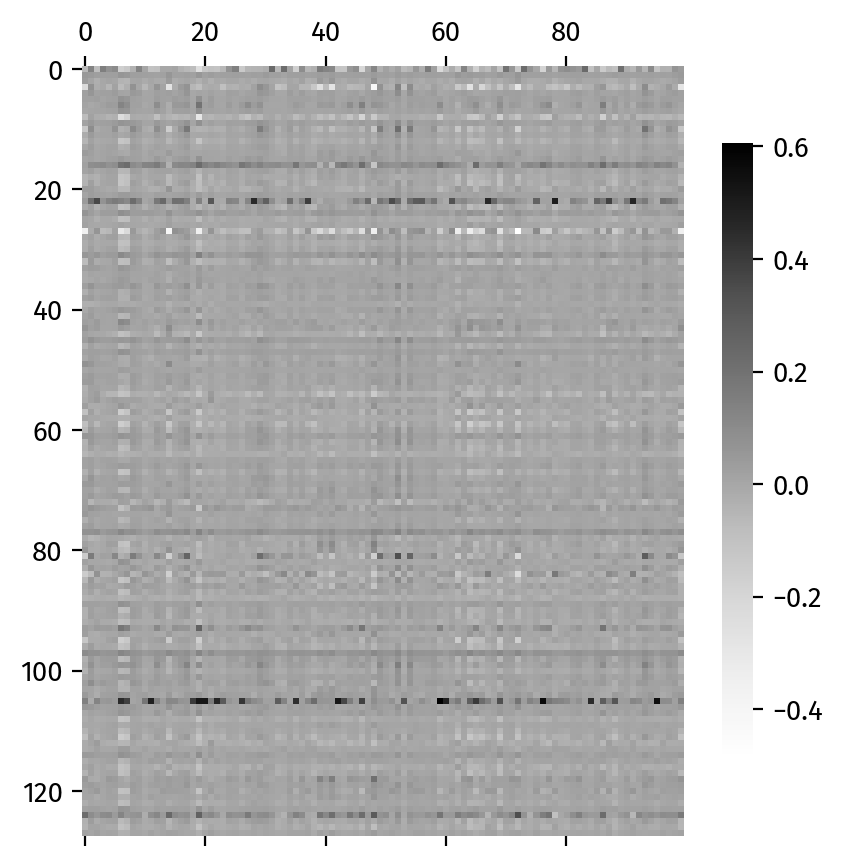

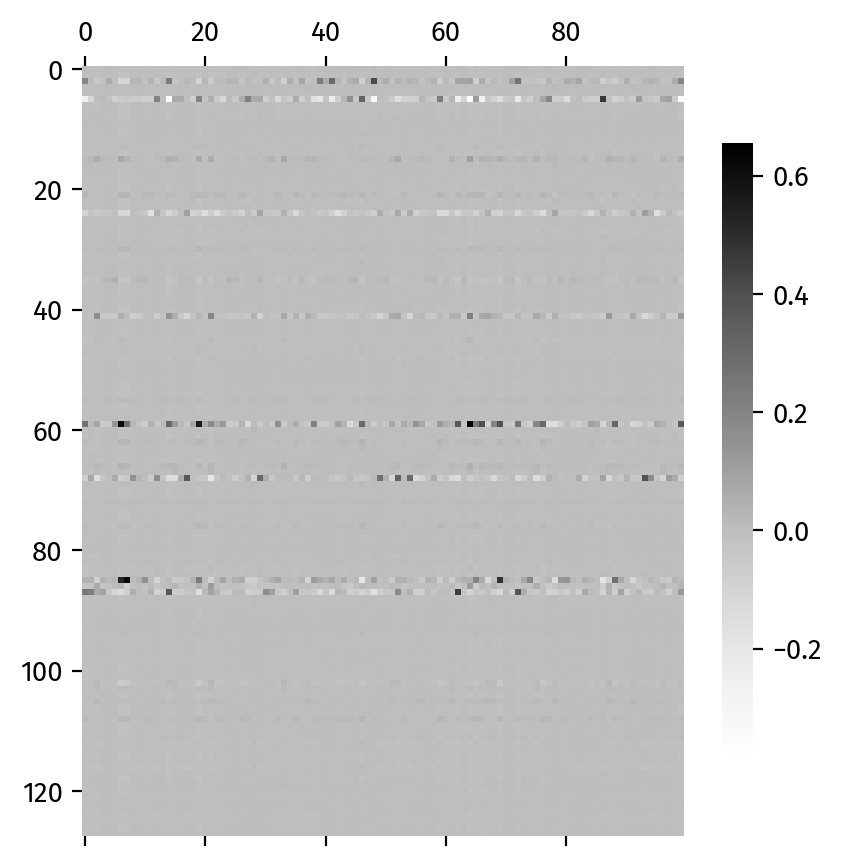

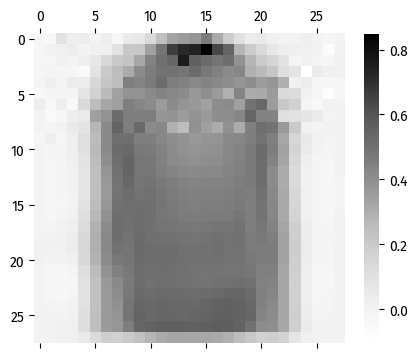

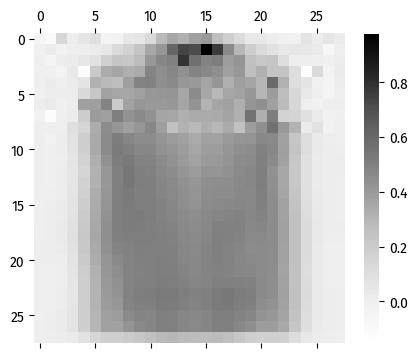

0.041269697 0.04085843
0.043463554 0.042531695
0.039262064 0.03972608
0.03693735 0.03565963
0.03562182 0.034623258


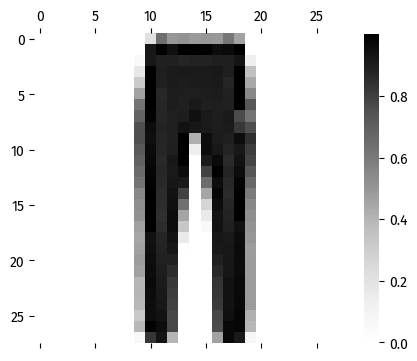

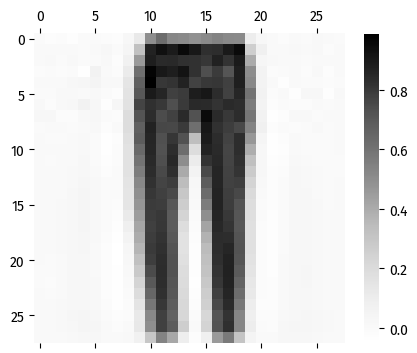

/home/owner/Projects/picojam/jam/notebooks/../berries/plot_utils.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, _ax = plt.subplots(figsize=(5, 5), dpi=dpi)


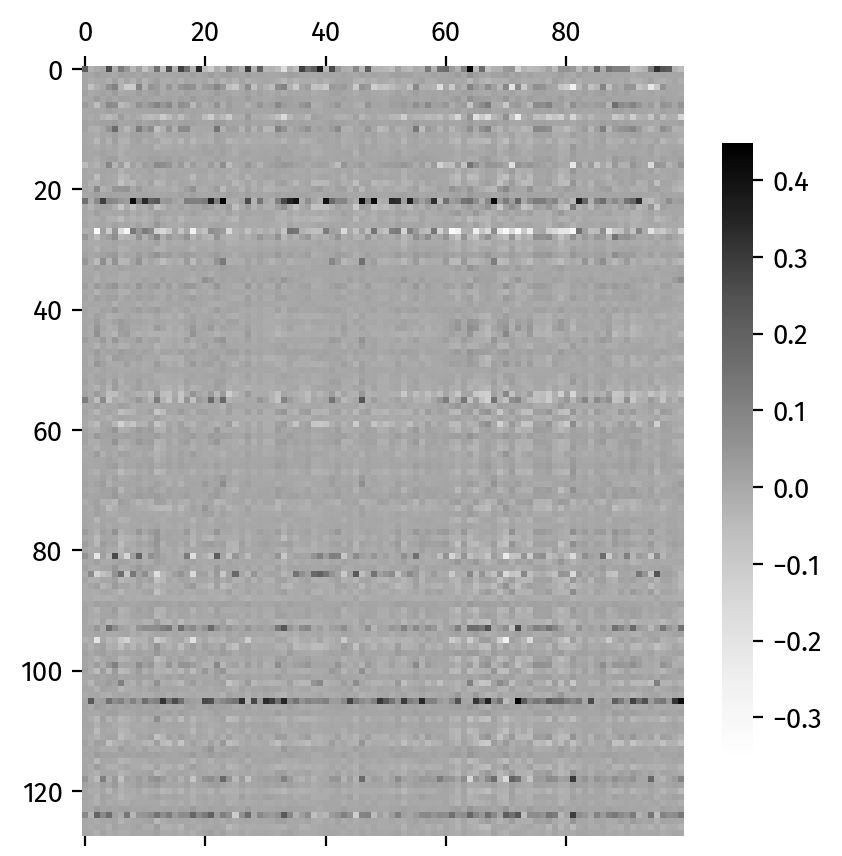

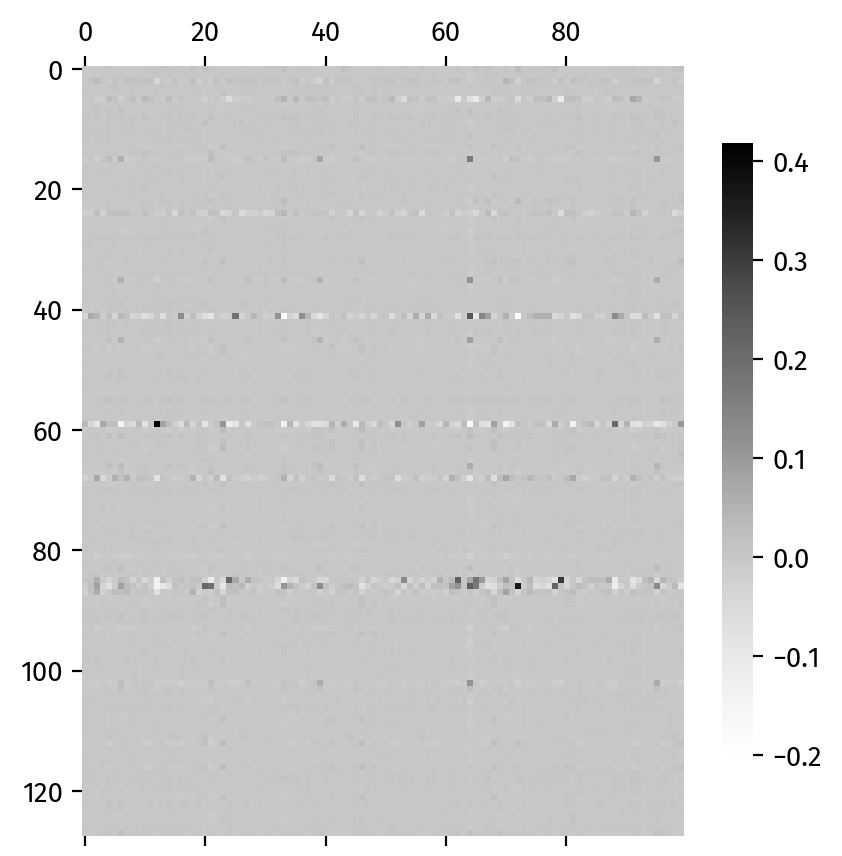

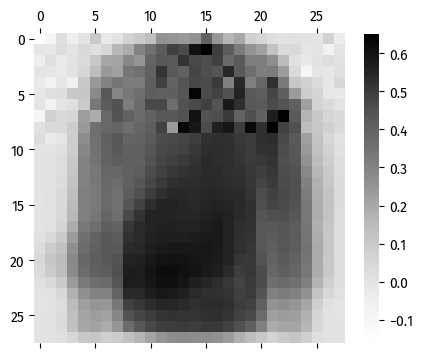

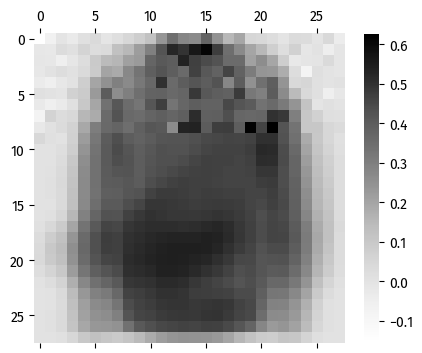

0.036600225 0.03679016
0.033830207 0.033525623
0.040367994 0.039006706
0.037955765 0.037074793
0.03329896 0.034092218


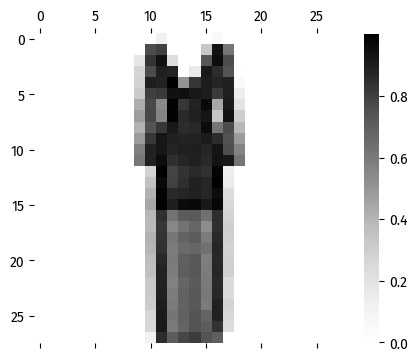

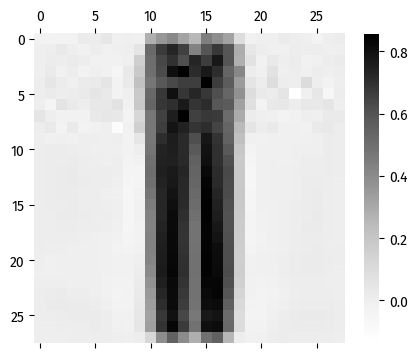

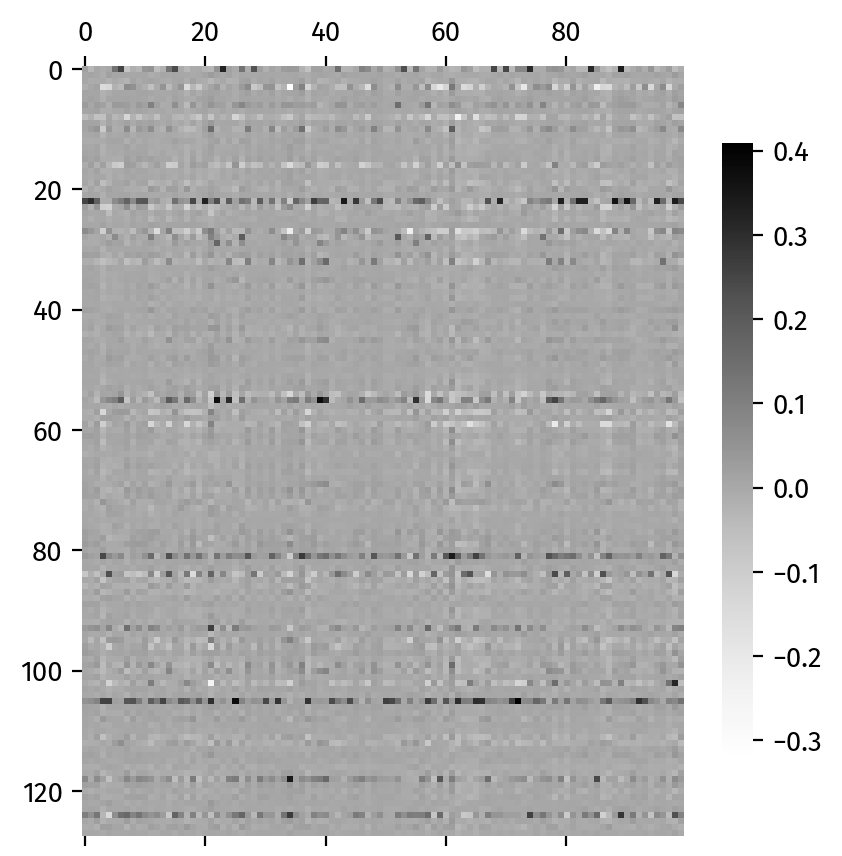

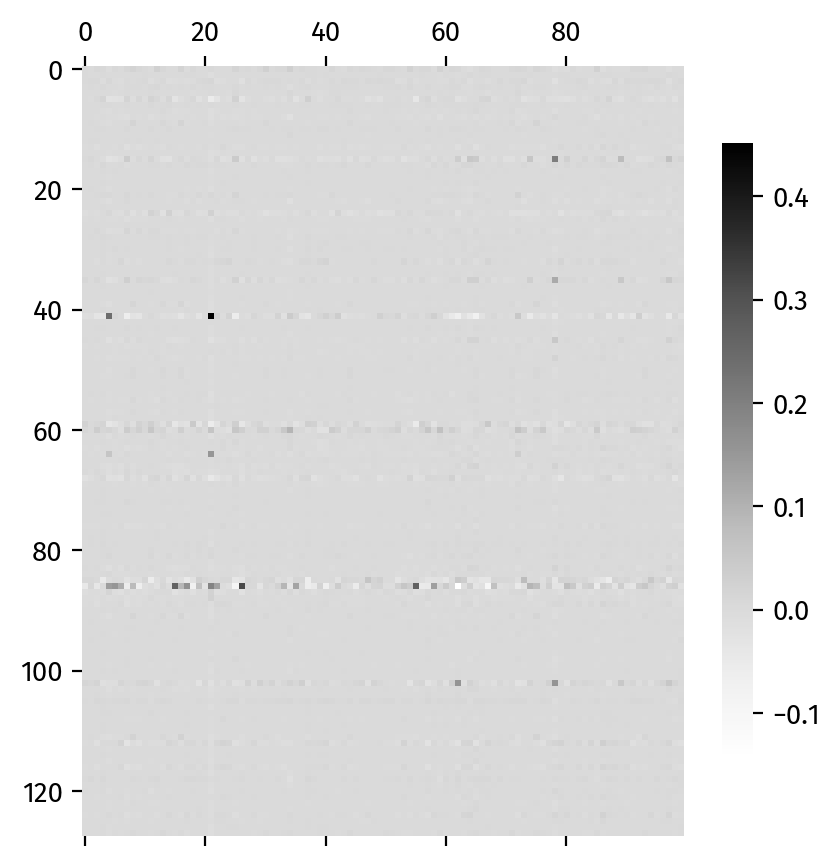

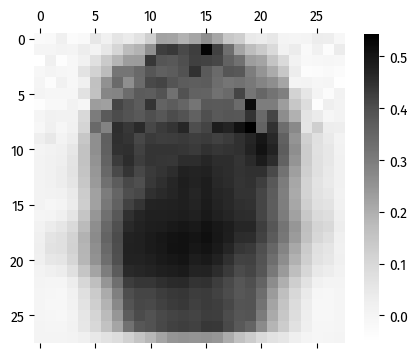

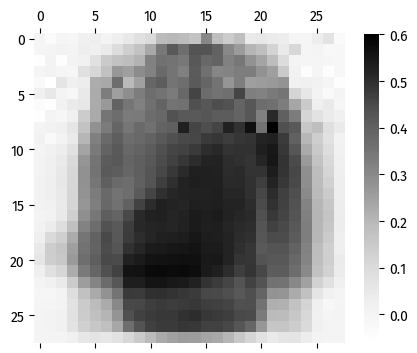

0.032620355 0.032899726
0.032980002 0.032943077
0.0314876 0.031125527
0.03321776 0.032992225
0.028775768


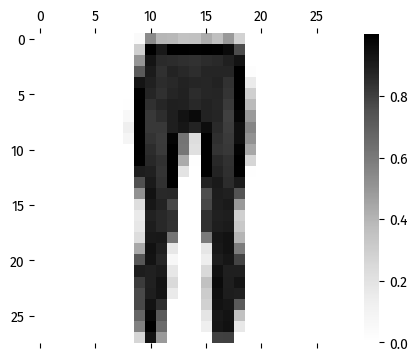

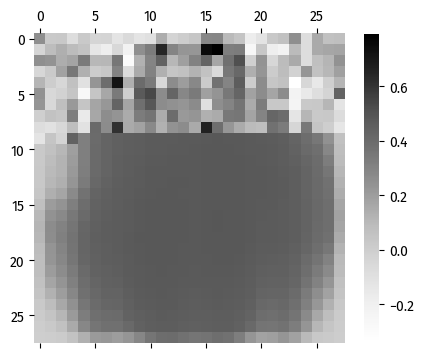

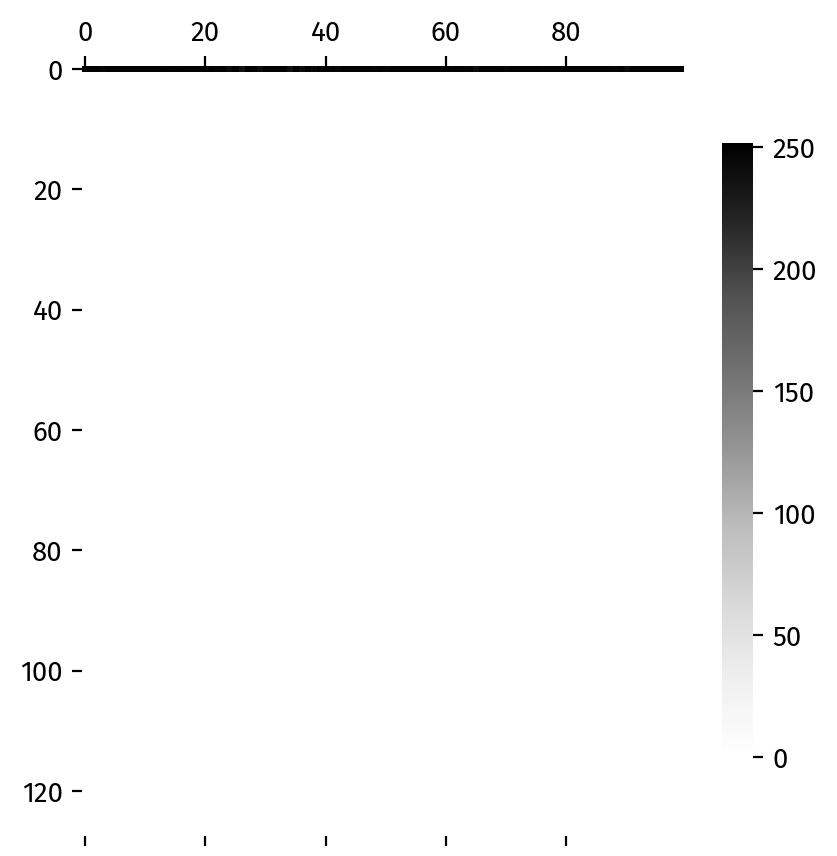

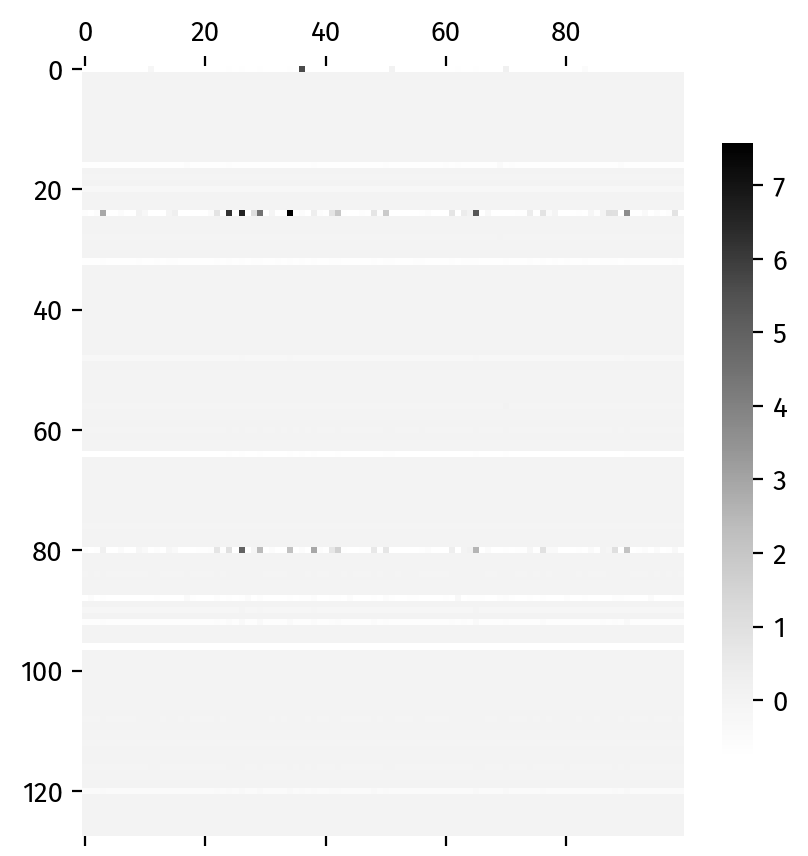

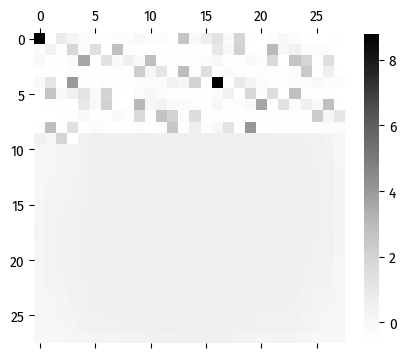

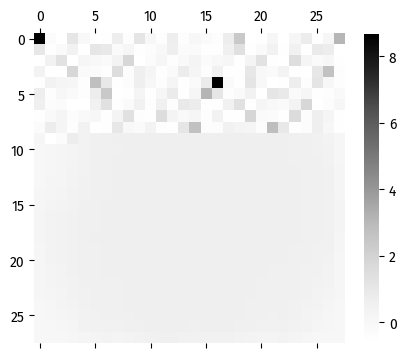

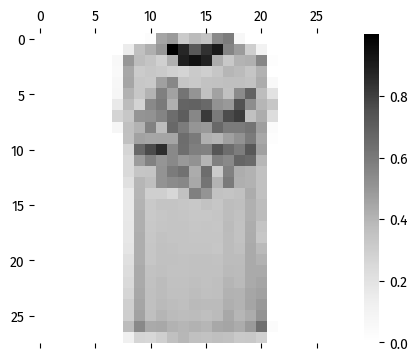

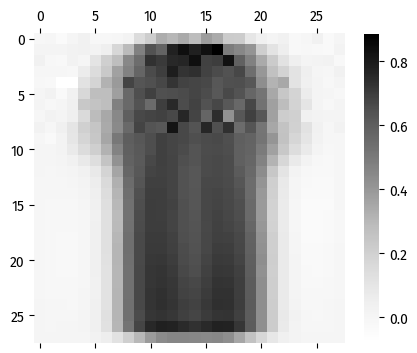

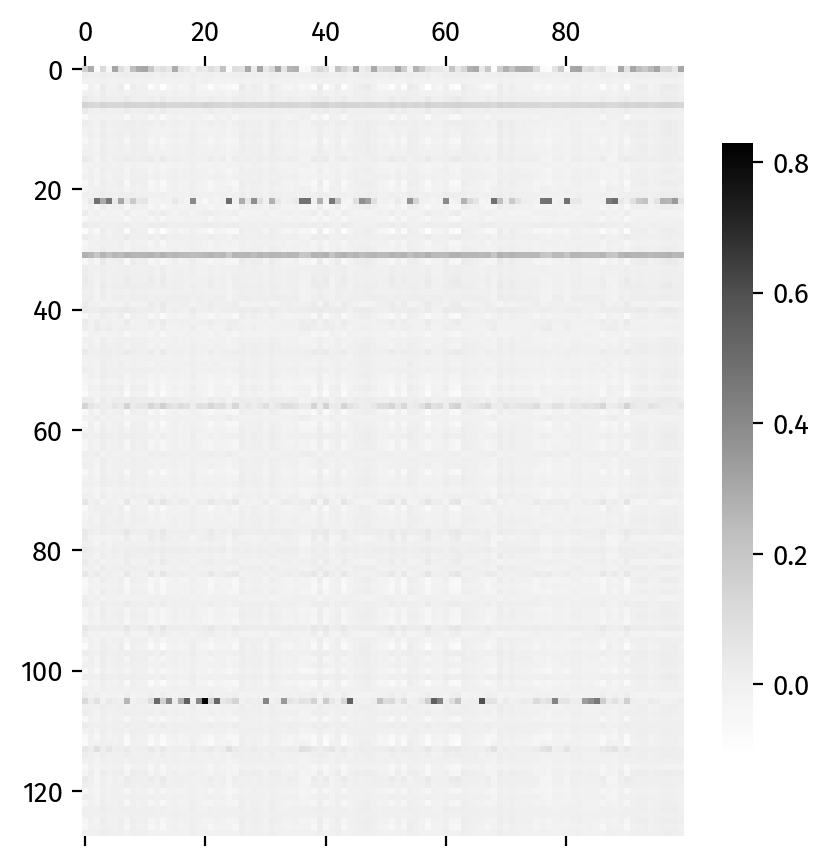

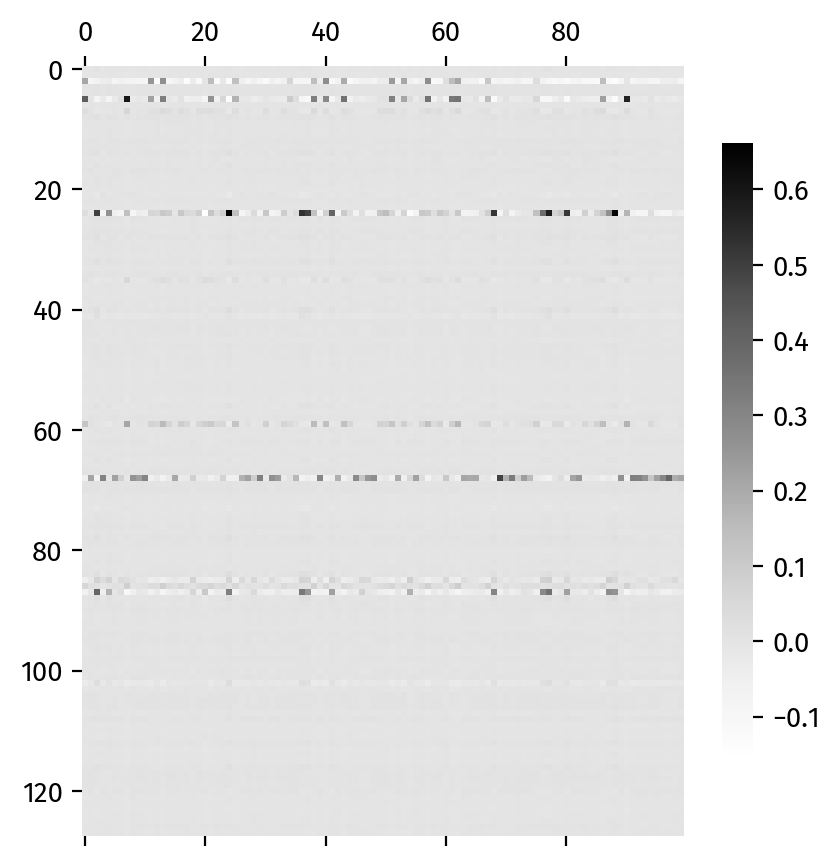

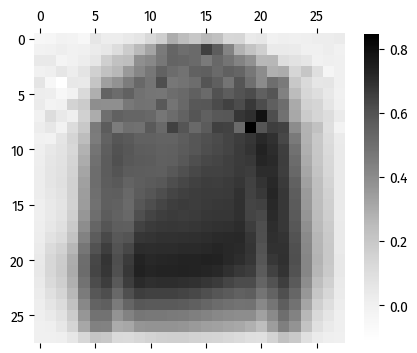

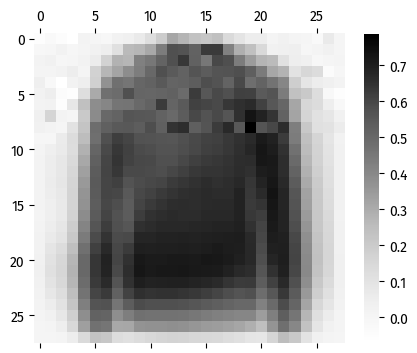

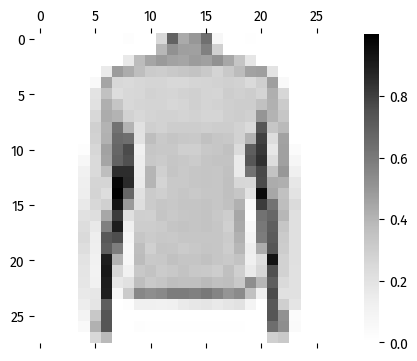

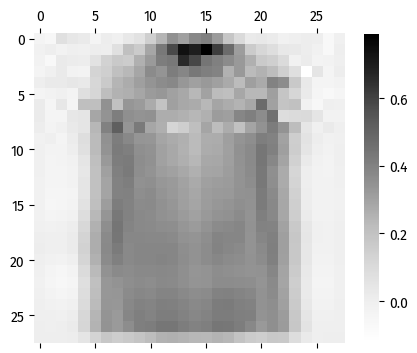

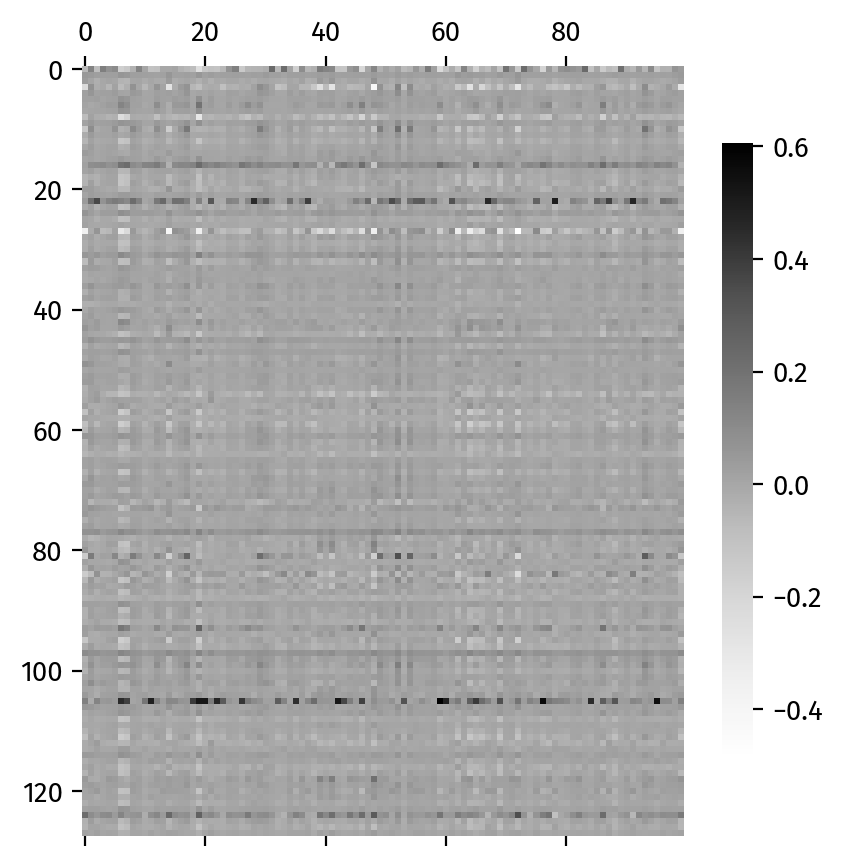

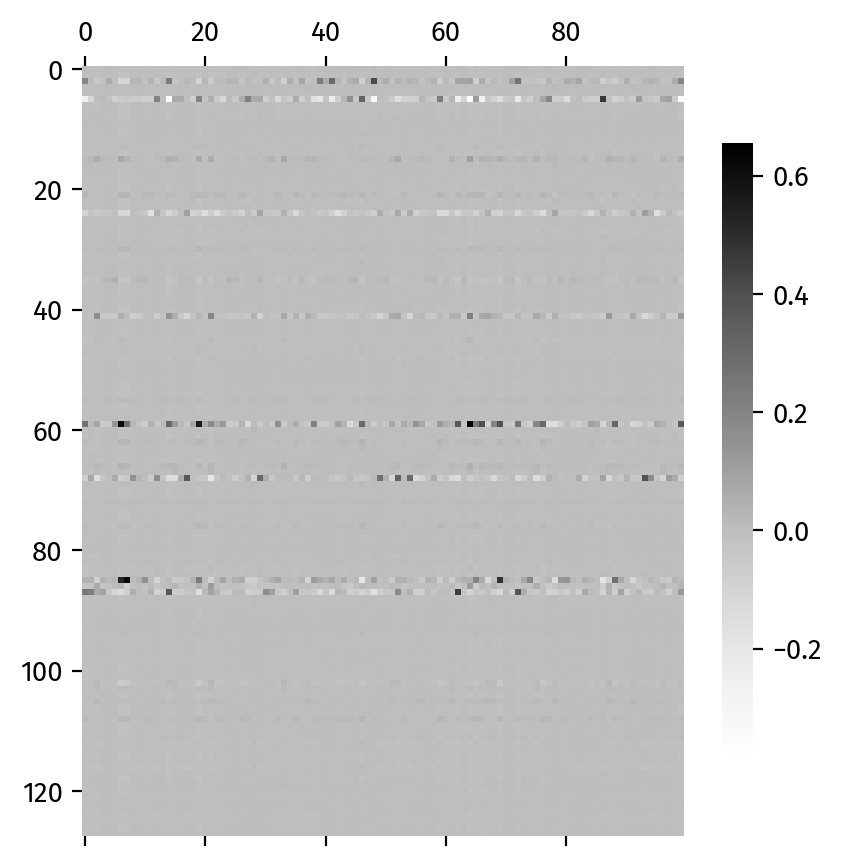

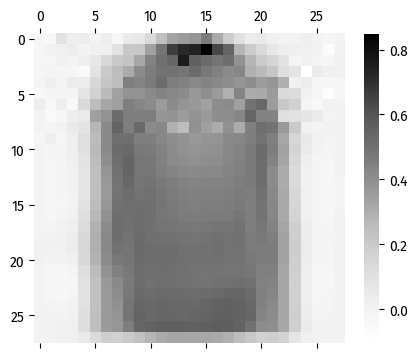

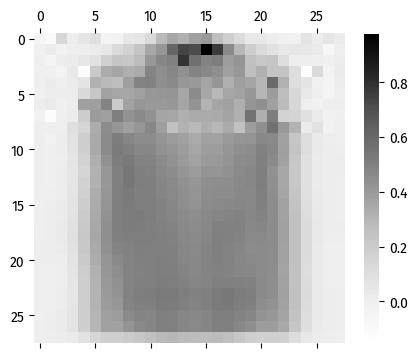

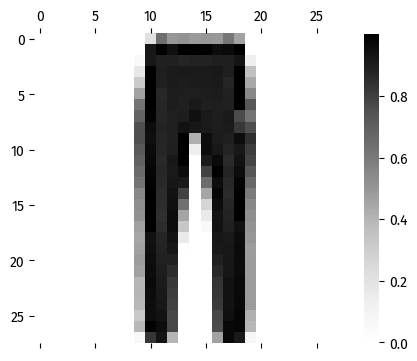

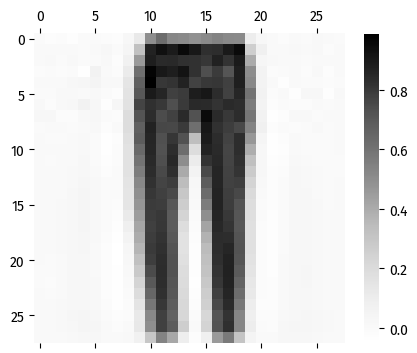

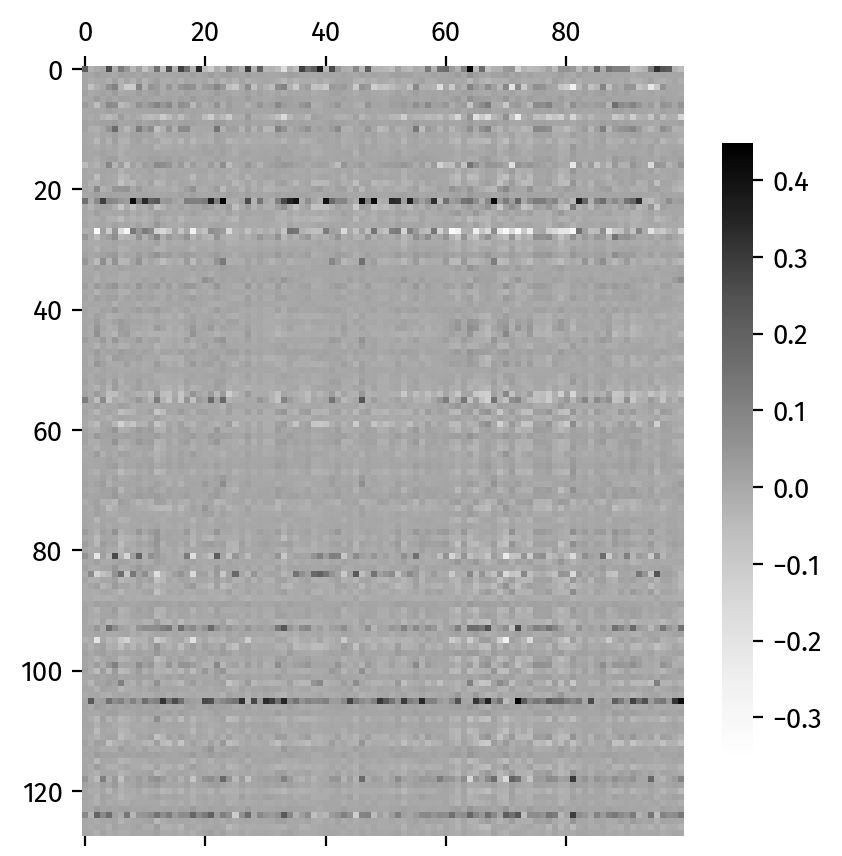

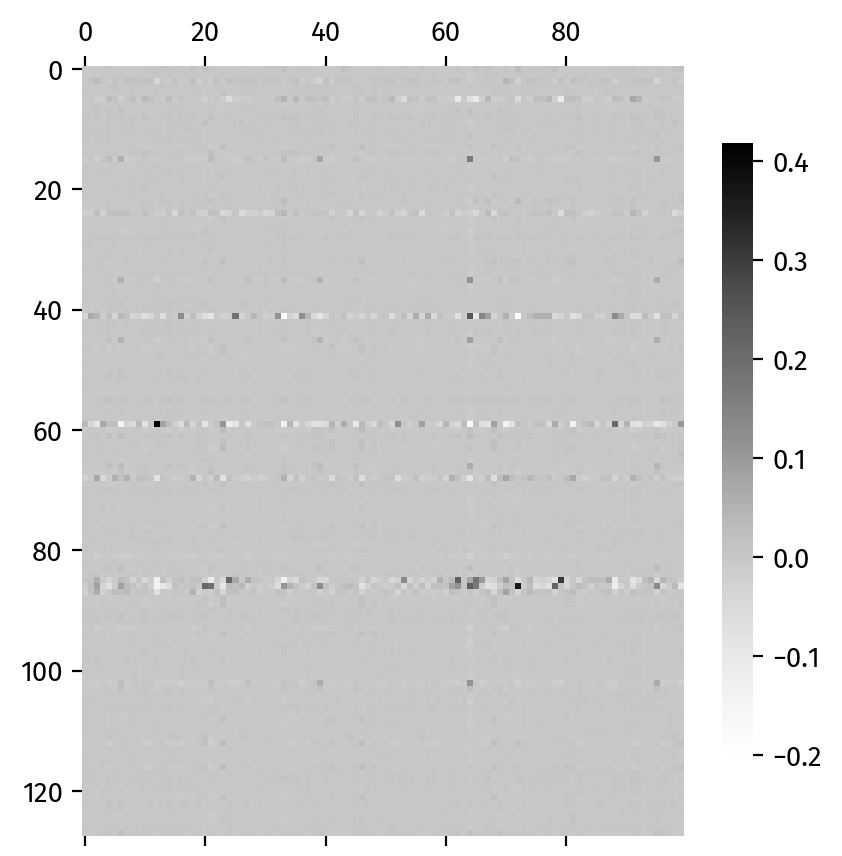

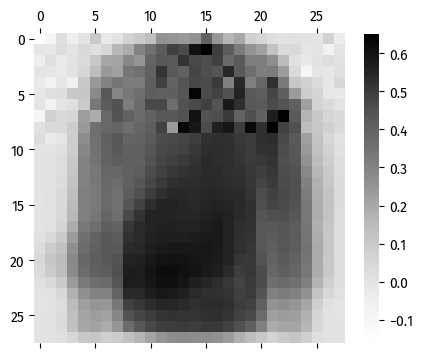

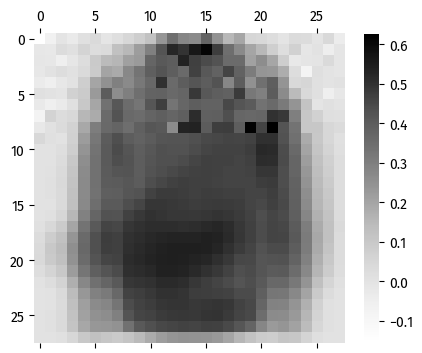

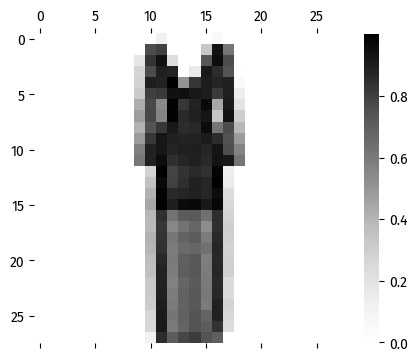

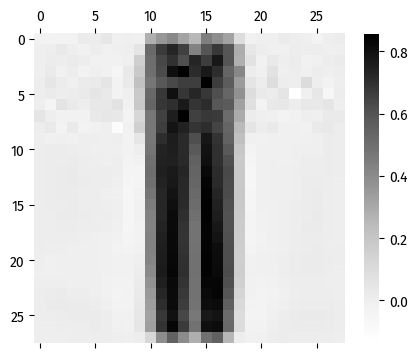

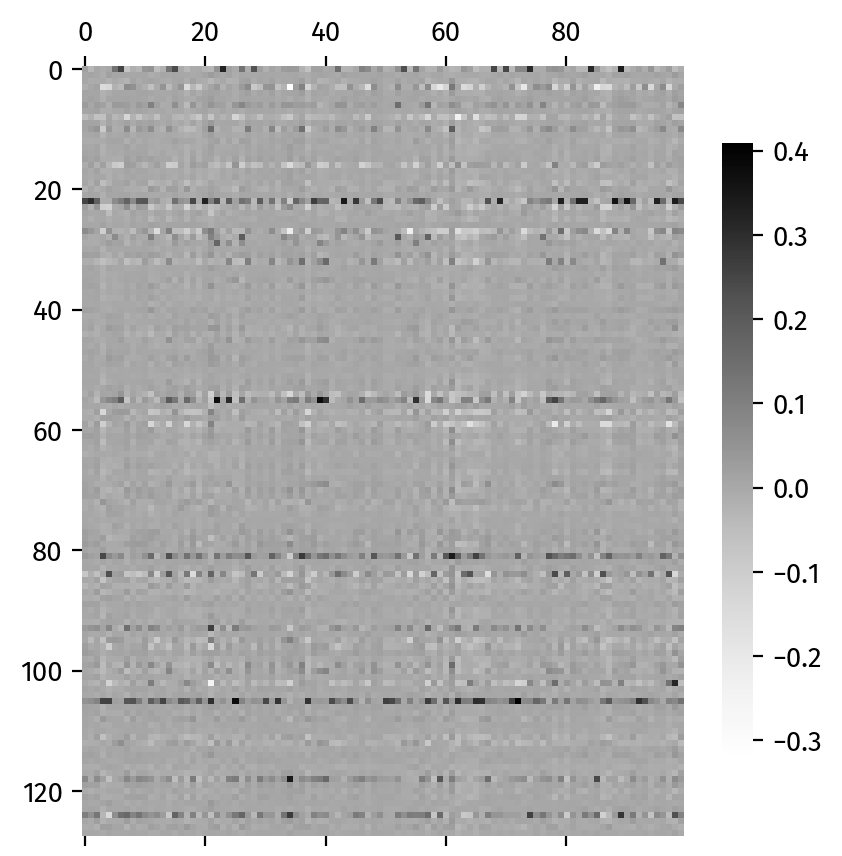

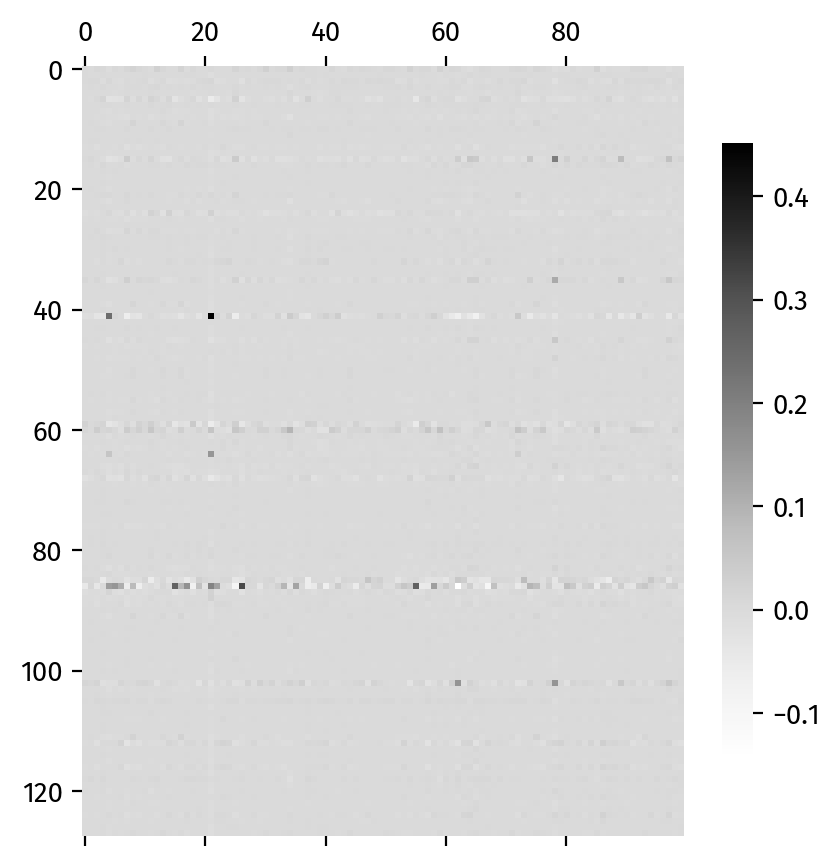

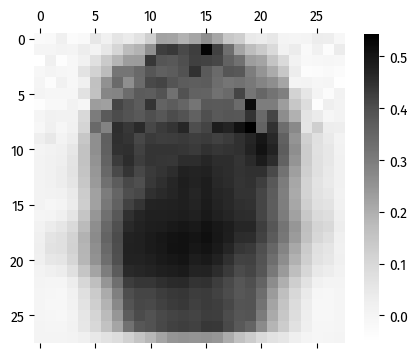

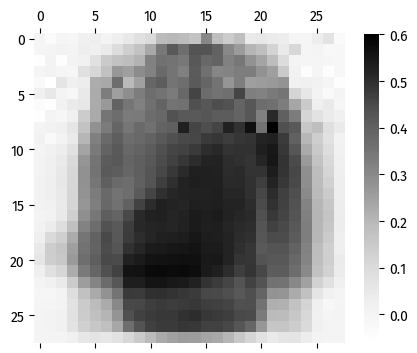

In [104]:
from plot_utils import visualize_matrix
from IPython.display import display
import math, random
import jax.numpy as np


loss_dt = test_loss_b.f(_, X_test)
loss_b_dt = loss_dt >> mean

def get_noise(size, key):
    return init_utils.normal_init(key, sd=0.1, shape=[size, d_vae_h])

batch_size = 1024

def sample():
    return X[random.sample(range(n_samples), batch_size), :]

for i in range(5000):
    key = next(key_gen)
    noise = get_noise(batch_size, key)
    data = sample()
    W, state = update(W, data, noise, state)
    if i % 200 == 0:
        print(loss_bm(W, data, noise), loss_b_dt(W))
    if i % 1000 == 0:
        # image_id = math.ceil(random.uniform(0, 1) * n_samples)
        plt, __, __ = visualize_matrix(data[image_id, :].reshape(28, 28), dpi=100)
        display(plt)

        # plt, __, __ = visualize_matrix(vae(W, X[image_id, :], noise[image_id, :])[0].reshape(28, 28), dpi=100)
        # display(plt)

        out, mu_, log_sigma_ = vae_b(W, data, noise)
        plt, __, __ = visualize_matrix(out[image_id].reshape(28, 28), dpi=100)
        display(plt)
        plt, __, __ = visualize_matrix(mu_[:100, :].T, dpi=200)
        display(plt)
        plt, __, __ = visualize_matrix(log_sigma_[:100, :].T, dpi=200)
        display(plt)

        # plt, __, __ = visualize_matrix(W['encoder']['sglu']['wo'], dpi=200)
        # display(plt)


        plt, __, __ = visualize_matrix(mglu_net(noise[0, :], W['decoder']).reshape(28, 28), dpi=100)
        display(plt)
        plt, __, __ = visualize_matrix(mglu_net(noise[20, :], W['decoder']).reshape(28, 28), dpi=100)
        display(plt)

print(loss_b_dt(W))
